__Задача #14 (5.1)__

Реализовать компьютерную симуляцию модели SIR:

* Логика модели:
    * каждый узел находится в одном из двух состояний $\{ S, I, R\}$
    * на 0-м шаге $c$ узлов устанавливаются в состояние $I$ (остальные - в $S$)
    * На каждом шаге каждый из инфецированных узлов с вероятностю $\beta$ заражает каждый из связанных с ним уязвимых узлов
    * Каждый инфецированный узел остается инфецированным $\tau_\gamma =1/\gamma$ временных шагов, после чего переходит в состояние $R$ и не может быть вновь инфецированным. Кроме того узлы в состоянии $R$ не распространяют инфекцию.

Сравнить симуляции динамики заражения узлов (в виде графиков динамики уязвимых, зраженных и резистентных узлов) сети модели для социальных сетей (не менее 3х) с несколькими тысячами узлов при 20% узлов обладают иммунитетом (т.е. изначально находятся в состоянии $R$) (например, в результате вакцинации). Рассматривается два варианта:
* узлы обладающие иммунитетом выбираются случайно (люди вакцинируются произвольно)
* иммунитет устанавливается у узлов с наибольшей степенью (вакцинируются наиболее контактные люди)

###

In [3]:
import networkx as nx
moreno_blogs = nx.read_edgelist(r"out.moreno_blogs_blogs", comments='%', nodetype=int)
powergrid_us = nx.read_edgelist(r"out.opsahl-powergrid", comments='%', nodetype=int)
cosmology_relativety = nx.read_edgelist(r"Relativety_Cosmology.txt", comments='#', nodetype=int)
hamster_friendships = nx.read_edgelist(r"out.petster-hamster", comments='%', nodetype=int)
NZ_dolphins = nx.read_edgelist(r"out.dolphins", comments='%', nodetype=int)

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

def SIR(G,init_n,proba,res_per,steps,vac_variant,nodes_s):
    nodes_zero_iteration = []
    pre_resistance = np.random.choice(list(G.nodes()),int(0.2*len(G.nodes())),replace = False)
    for i in G.nodes.data():
        if vac_variant == 1:#первый вариант пре-вакцинации, случайный выбор узлов
            if i[0] in pre_resistance:
                i[1]['status']=['resistant']
            else:
                i[1]['status']=['undefined']
                nodes_zero_iteration.append(i[0])
        if vac_variant == 2:#второй вариант пре-вакцинации, вакцинируются наиболее контактные люди
            i[1]['status'] = ['undefined']
            for j in sorted(dict(G.degree).items(), key=lambda x: x[1],reverse = True)[0:int(0.2*len(G.nodes()))]:
                if i[0] == j[0]:
                    i[1]['status']=['resistant']
            if i[1]['status'] == ['undefined'] :
                nodes_zero_iteration.append(i[0])

                                
    first_ill = np.random.choice(nodes_zero_iteration,init_n,replace = False)#0-ой шаг, заражение первых n узлов без иммунитета
    print('first_ill ',first_ill)
    node_coloring = []
    S_count = I_count = R_count = 0#считаем количество относящихся к S,I,R для графика
    for i in G.nodes.data():
        if i[0] in first_ill:
            i[1]['status']=['ill']
            i[1]['resistance_period'] = 0
            node_coloring.append('red')
            I_count+=1
        if i[1]['status'] != ['resistant'] and i[0] not in first_ill:
            i[1]['status']=['healthy']
            i[1]['resistance_period'] = -1
            node_coloring.append('green')
            S_count+=1
        if i[1]['status'] == ['resistant']:
            i[1]['resistance_period'] = -1
            node_coloring.append('blue')
            R_count+=1
    S_plot = [S_count]#Вносим количество S и далее в список для отрисовки в дальнейшем
    I_plot = [I_count]
    R_plot = [R_count]
    
    plt.figure(0)#отрисовка 0-го шага, labels рисуются/не рисуются в зависимости от размера вершин
    if nodes_s<250:
        nx.draw_networkx(G,node_color = node_coloring,pos = nx.spring_layout(G,seed=10),with_labels = False,node_size=nodes_s)
    else:
        nx.draw_networkx(G,node_color = node_coloring,pos = nx.spring_layout(G,seed=10),with_labels = True,node_size=nodes_s)
        
    for step in range(0,steps-1,1): #задаем цикл количества итераций заболеваемости
        ill_nodes = []
        for i in G.nodes.data():#присвоение иммунитета людям, болевшим "тета" временных отрезков
            if i[1]['resistance_period'] == res_per:
                i[1]['status'] = ['resistant']
                
        for i in G.nodes.data():#заражение с заданной вероятностью соседей больных людей
            if i[1]['status']==['ill']:
                for j in G.neighbors(i[0]):
                    random_proba = random.random()#можно было обойтись без присваивания, но так можно вывести вероятности и понять, что заражение происходит правильно
                    #print('step{},probability{}'.format (step,random_proba))
                    if random_proba<proba:
                        ill_nodes.append(j)              
            
        for i in set(ill_nodes):#из списка потенциально зараженных узлов узлы, которые не обладают иммунитетом, заражаются
            for j in G.nodes.data():
                if i == j[0] and j[1]['status']!=['resistant']:
                    j[1]['status']=['ill']
                    
        for i in G.nodes.data():#добавление шага к времени заражения
            if i[1]['status'] == ['ill']:
                i[1]['resistance_period'] +=1
            
        node_coloring = []
        S_count = I_count = R_count = 0
        for i in G.nodes.data():#отрисовка узлов
            if i[1]['status']==['ill']:
                node_coloring.append('red')
                I_count+=1
            if i[1]['status']==['healthy']:
                node_coloring.append('green')
                S_count+=1
            if i[1]['status'] == ['resistant']:
                node_coloring.append('blue')
                R_count+=1
         
        S_plot.append(S_count)#добавляем в список динамики S,I,R
        I_plot.append(I_count)
        R_plot.append(R_count)
        plt.figure(step+1)#отрисовка шага в графе
        if nodes_s < 250:
            nx.draw_networkx(G,node_color = node_coloring,pos = nx.spring_layout(G,seed=10),with_labels = False,node_size=nodes_s)
        else:
            nx.draw_networkx(G,node_color = node_coloring,pos = nx.spring_layout(G,seed=10),with_labels = True,node_size=nodes_s)
    
    plt.figure(steps+1)#отрисовка динамик
    plt.grid()
    plt.title('Динамика количества уязвимых вершин')
    plt.scatter(range(len(S_plot)),S_plot,color = 'green')
    plt.plot(range(len(S_plot)),S_plot,color = 'green')
    plt.figure(steps+2)
    plt.grid()
    plt.title('Динамика количества инфицированных вершин')
    plt.scatter(range(len(I_plot)),I_plot, color = 'red')
    plt.plot(range(len(I_plot)),I_plot, color = 'red')
    plt.figure(steps+3)
    plt.grid()
    plt.title('Динамика количества резистентных вершин')
    plt.scatter(range(len(R_plot)),R_plot, color = 'blue')
    plt.plot(range(len(R_plot)),R_plot, color = 'blue')
        
            
if __name__ == '__main__':
    SIR(moreno_blogs,30,0.3,4,8,2,20) #Граф ; Начальное количество заболевших ;Вероятность передать заболевание;
#Сколько шагов "тау" необходимо для перехода из I в R(причем в количество шагов не включается шаг заражения,также 
#в шаг заражения вершина не передает заболевание) ; количество шагов итератора; стратегия вакцинации (1-случайные 20%,2-
#- 20% вершин с наибольшей степенью); размер вершин на рисунке графа, сделал его изменяемым для лучшей интерпретации графов разного
#размера;

first_ill  [ 793 1741 2632 4611 1869 3621  962  352 3222 4198]


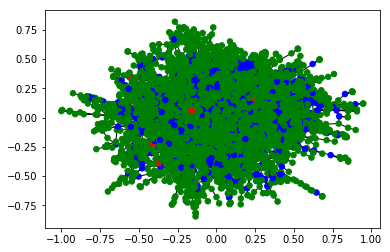

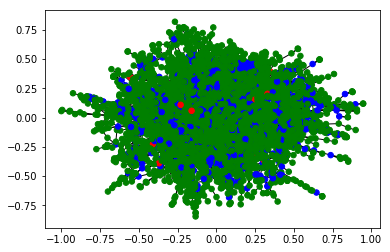

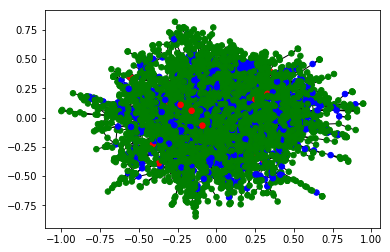

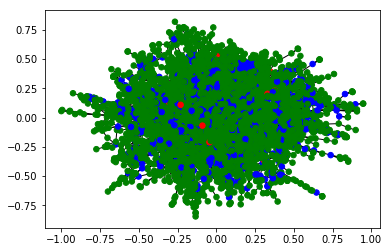

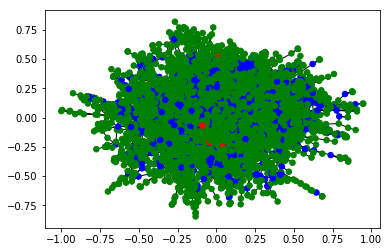

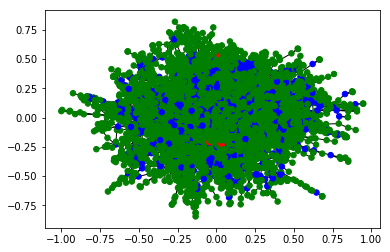

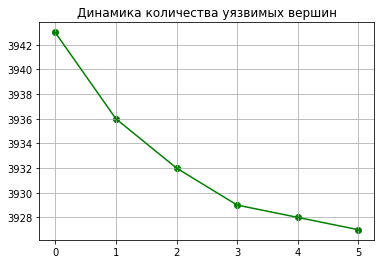

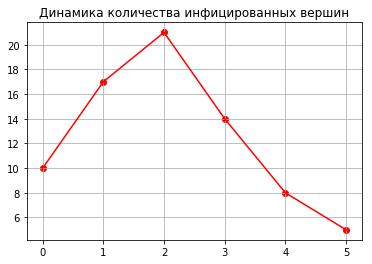

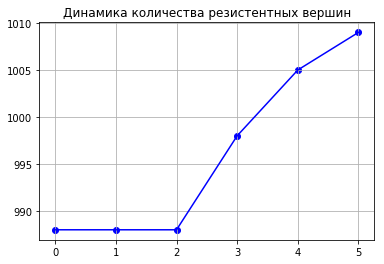

In [4]:
SIR(powergrid_us,10,0.4,2,6,2,30)

first_ill  [2080   31 1779 2160   14 2144  863 1516 1084  874  817 1612 1008  830
 1661 2384 2090 1247 1275 1307]


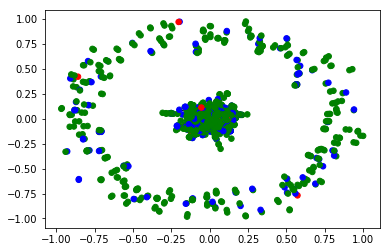

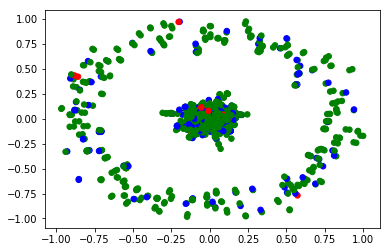

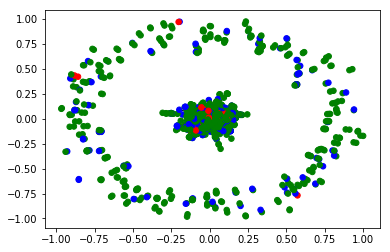

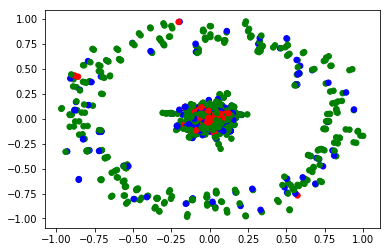

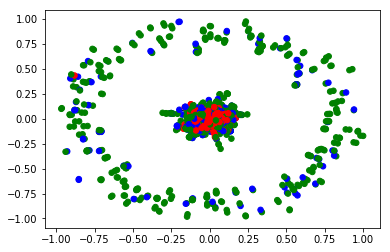

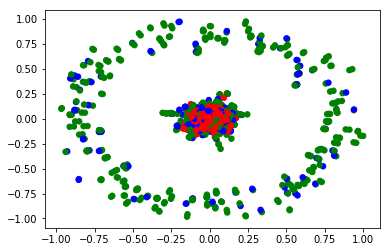

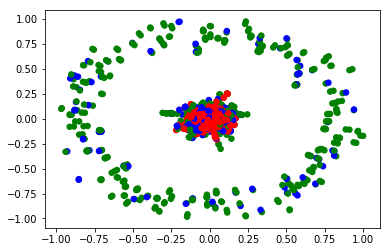

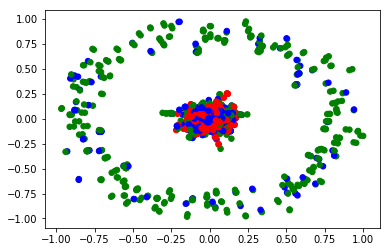

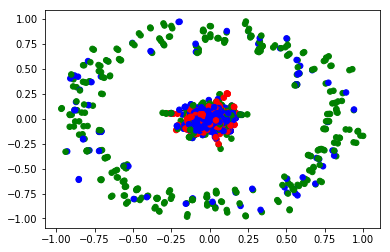

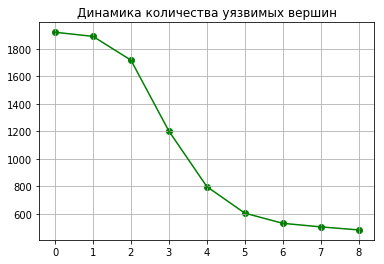

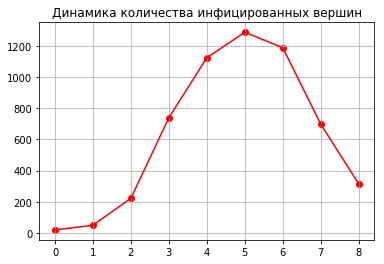

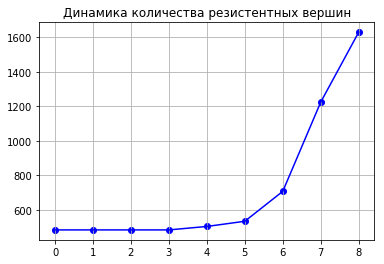

In [20]:
SIR(hamster_friendships,20,0.31,3,9,1,30)

first_ill  [10358  7477 21401  8534  1092  2762  7727 19791   193 20774 10897  9027
 25469 20305  4110 14932 23215 22748 22645 14840]


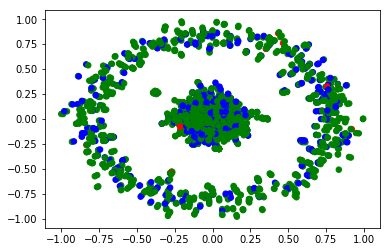

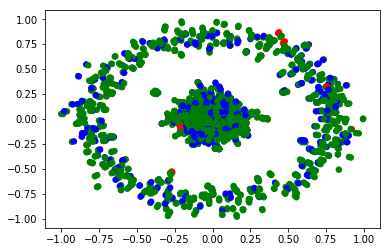

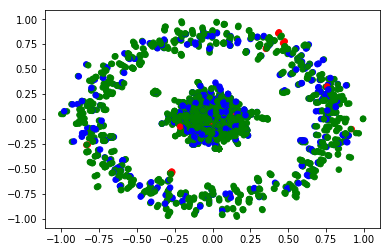

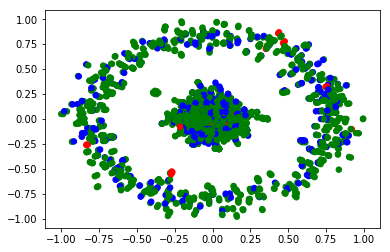

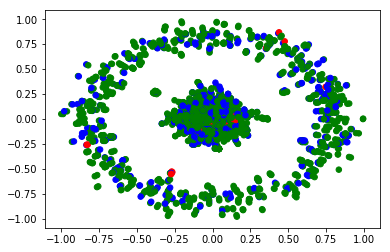

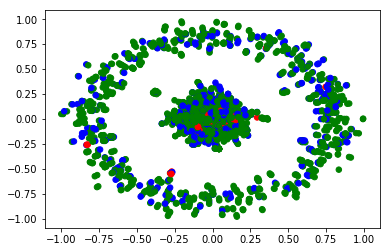

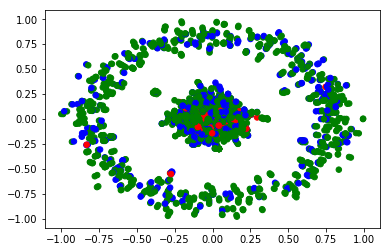

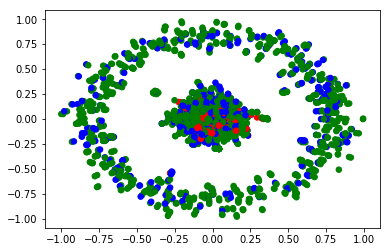

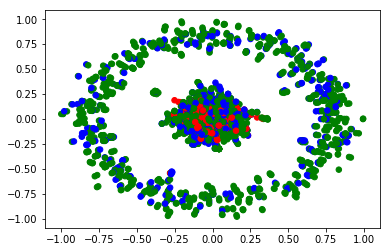

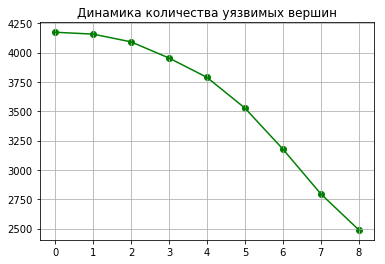

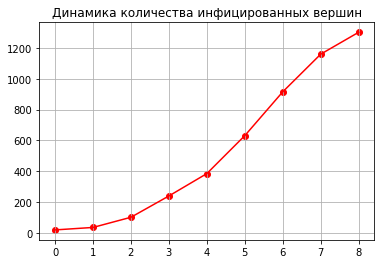

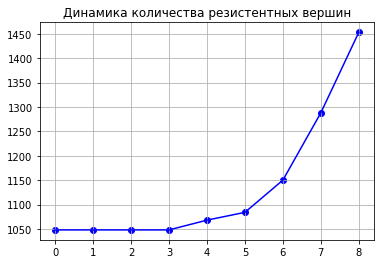

In [21]:
SIR(cosmology_relativety,20,0.295,3,9,1,30)

first_ill  [56 55 19 44 60]


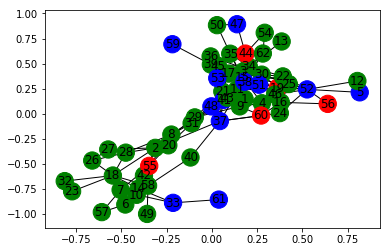

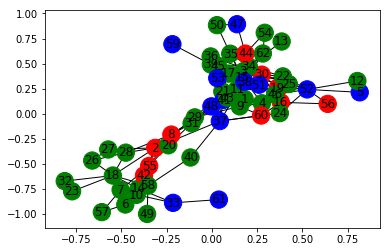

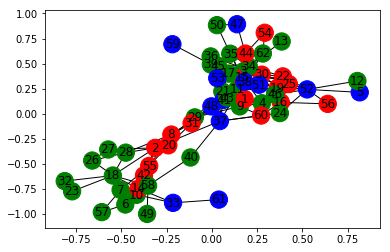

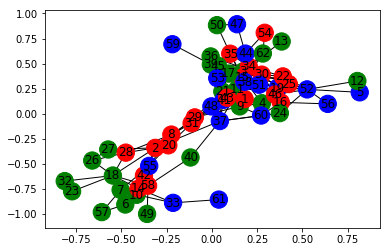

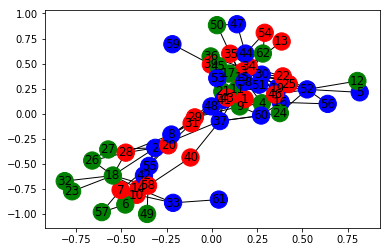

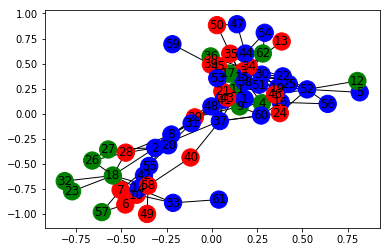

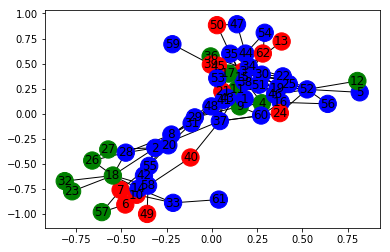

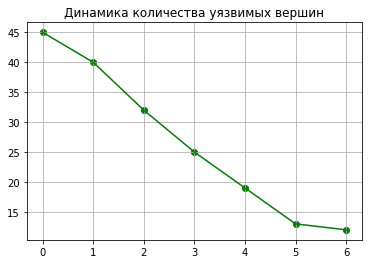

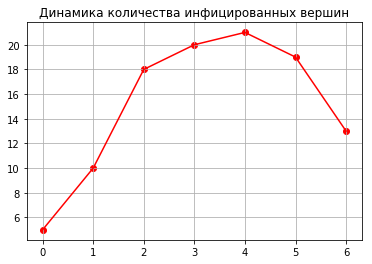

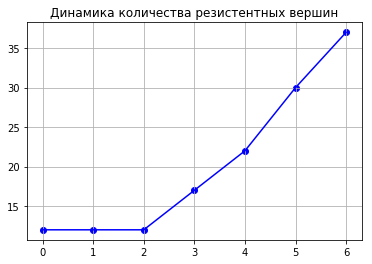

In [38]:
#но наиболеее показательным примером будет малое сообщество, в данном случае всего 62 вершины
SIR(NZ_dolphins,5,0.25,2,7,1,300)

first_ill  [20 24 22 15  7]


C:\Users\User\Music\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


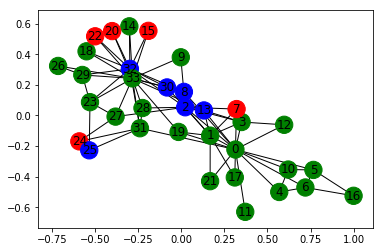

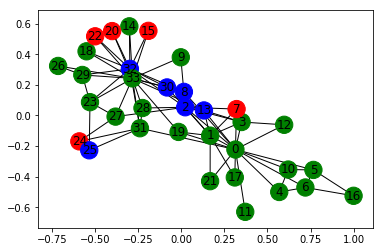

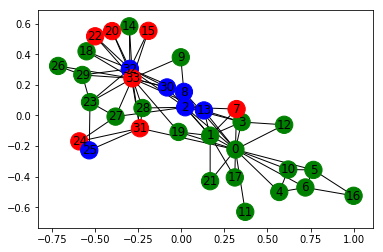

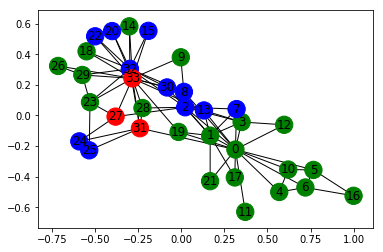

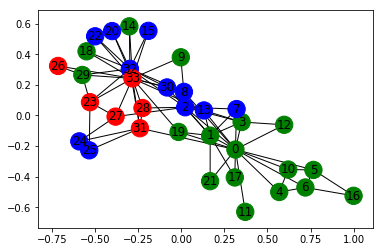

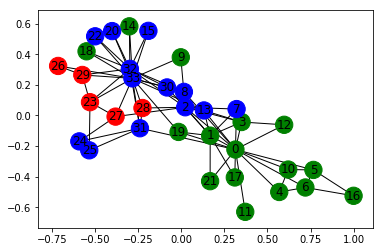

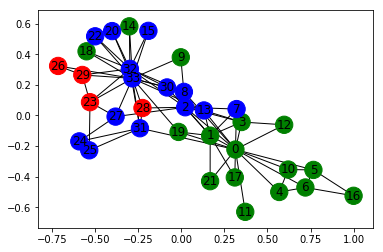

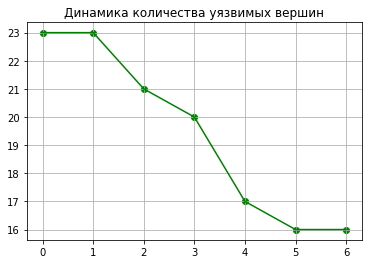

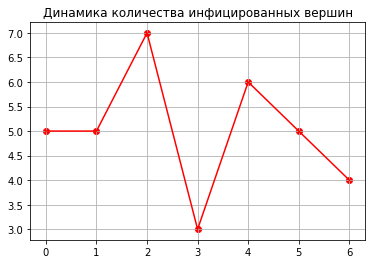

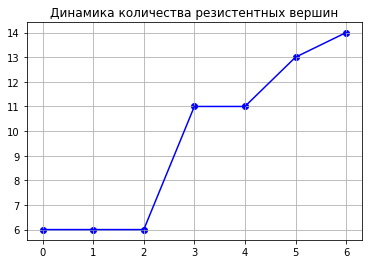

In [4]:
SIR(nx.karate_club_graph(),5,0.25,2,7,1,300)